In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error,median_absolute_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
!pip install catboost
from catboost import CatBoostRegressor
import os
# Monter le Drive
from google.colab import drive
drive.mount('/content/drive')
# Changer de répertoire vers SteamAnalyse
project_dir = '/content/drive/MyDrive/SteamAnalyse'
os.chdir(project_dir)

path="train.parquet"
path_test="test.parquet"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.6 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
df = pd.read_parquet(path)
dft = pd.read_parquet(path_test)

In [ ]:
def clean_text_col(x):
    if isinstance(x, (list, np.ndarray)):
        return " ".join([str(i) for i in x])
    return str(x) if pd.notna(x) else ""

In [ ]:
cols_text = ["categories","genres","tags_utilisateurs","langues_partiel","langues_complet","description_detaillee"]
numeric_cols = ["prix","nombre_succes","N_langues_complet","N_langues_partiel"]

# Vérification que les colonnes existent
features = numeric_cols + cols_text
target = "review"

X_train = df[features].copy()
for c in cols_text: X_train[c] = X_train[c].apply(clean_text_col)
y_train = np.log1p(df[target])

In [ ]:
cols_text = ["categories","genres","tags_utilisateurs","langues_partiel","langues_complet","description_detaillee"]
numeric_cols = ["prix","nombre_succes","N_langues_complet","N_langues_partiel"]

# Vérification que les colonnes existent
features = numeric_cols + cols_text
target = "review"

X_test = dft[features].copy()
for c in cols_text: X_test[c] = X_test[c].apply(clean_text_col)
y_test = df[target]

Entraînement sur le texte : ['categories', 'genres', 'tags_utilisateurs', 'langues_partiel', 'langues_complet', 'description_detaillee']...
Learning rate set to 0.094416
0:	learn: 1.9676537	test: 1.9411329	best: 1.9411329 (0)	total: 907ms	remaining: 15m 5s
100:	learn: 1.1087956	test: 1.1699023	best: 1.1699023 (100)	total: 1m 6s	remaining: 9m 50s
200:	learn: 1.0466731	test: 1.1421000	best: 1.1421000 (200)	total: 2m 11s	remaining: 8m 43s
300:	learn: 1.0119266	test: 1.1299893	best: 1.1299893 (300)	total: 3m 16s	remaining: 7m 36s
400:	learn: 0.9813022	test: 1.1197396	best: 1.1197396 (400)	total: 4m 21s	remaining: 6m 30s
500:	learn: 0.9597063	test: 1.1137289	best: 1.1137289 (500)	total: 5m 25s	remaining: 5m 24s
600:	learn: 0.9439320	test: 1.1099154	best: 1.1097919 (585)	total: 6m 30s	remaining: 4m 19s
700:	learn: 0.9278197	test: 1.1058426	best: 1.1058426 (700)	total: 7m 35s	remaining: 3m 14s
800:	learn: 0.9109983	test: 1.1017590	best: 1.1017590 (800)	total: 8m 40s	remaining: 2m 9s
900:	lear

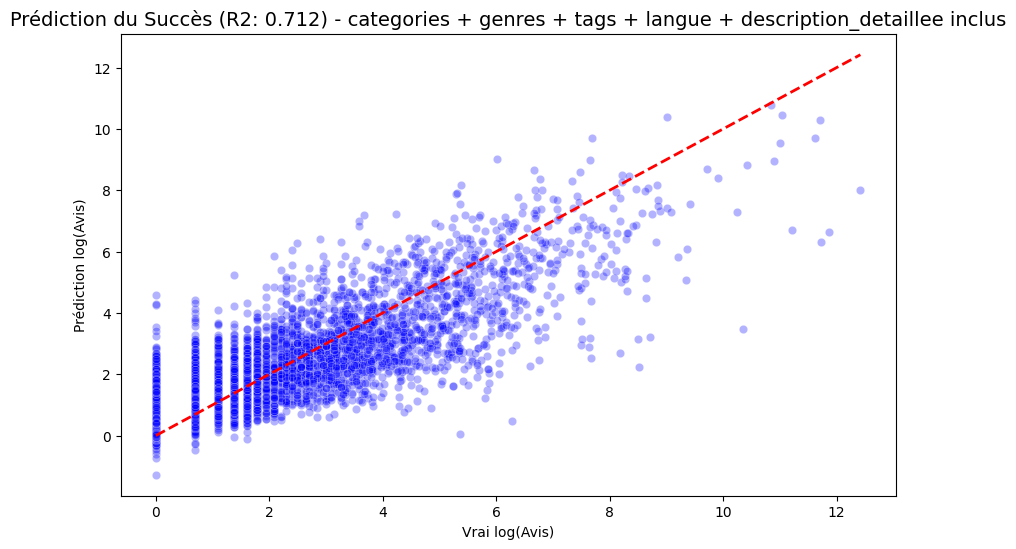

Exemples de prédictions :
                              Titre  Vrai_Avis  Prediction
31990  Mini Airways - ATC simulator        382  286.979747
15445                  Lost in Vivo       2783  209.399938
59927         Lewis Carroll's Alice          4    3.158192
65567                 Cursed Canvas          0    0.031467
72792                The 13th Floor          1    4.436037
48497                         Fused          6    2.044153
33158                          桃色武林          3    8.014319
56138                   TCSTRIKERS4          0    2.056927
16239                 Lost Daughter          1    4.585697
49201              Partition Sector          2    1.823089
              Feature Id  Importances
0             categories    28.214790
1                   prix    22.784486
2      tags_utilisateurs    22.483542
3  description_detaillee    10.259937
4          nombre_succes     5.083739
5                 genres     3.798066
6        langues_partiel     3.485839
7      N_langues_part

In [ ]:
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

y_test_original_scale = dft[target].copy()
y_test_eval = np.log1p(y_test_original_scale)

cb = CatBoostRegressor(
    depth=12,
    text_features=cols_text,
    verbose=100,
    task_type="GPU"
)

print(f"Entraînement sur le texte : {cols_text}...")
cb.fit(X_train, y_train, eval_set=(X_test, y_test_eval))


# 5. Résultats
y_pred_log = cb.predict(X_test)
score_r2 = r2_score(y_test_eval, y_pred_log)
y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test_original_scale, y_pred)))
score_r2_train = r2_score(y_train, cb.predict(X_train))
print(f"\n SCORE TRAIN (R2 Log) : {score_r2_train:.4f}")
print("Erreur Médiane :", median_absolute_error(y_test_original_scale, y_pred))

imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))


plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_eval, y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, y_test_eval.max()], [0, y_test_eval.max()], 'r--', lw=2)
plt.title(f"Prédiction du Succès (R2: {score_r2:.3f}) - categories + genres + tags + langue + description_detaillee inclus", fontsize=14)
plt.xlabel("Vrai log(Avis)")
plt.ylabel("Prédiction log(Avis)")
plt.show()

results = pd.DataFrame({
    'Titre': dft.loc[X_test.index, 'nom'] if 'nom' in dft.columns else X_test.index,
    'Vrai_Avis': y_test_original_scale,
    'Prediction': y_pred
})

print("Exemples de prédictions :")
print(results.sample(10))
feature_importance = cb.get_feature_importance(prettified=True)
print(feature_importance)